# Project 2: Sentiment Analysis of 2021 Canadian Election Tweets

Name: Tianyu Shi;

Email: ty.shi@mail.utoronto.ca

##### Import Library

In [1]:
import numpy as np
import pandas as pd
import re
import html
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

import gensim
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.neural_network import MLPClassifier


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/tianyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data cleaning 
The tweets contain too much ‘noise’. Prepares the Twitter data for analysis by satisfying:

    ✓ All html tags and attributes (i.e., /<[^>]+>/) are removed.
    ✓ Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
     (https://wiki.python.org/moin/EscapingHtml)
    ✓ All URLs are removed.
    ✓ All characters in the text are in lowercase.
    ✓ All stop words are removed. Be clear in what you consider as a stop word.
    ✓ If a tweet is empty after pre-processing, it should be preserved as such.

    Design two different text cleaning procedures for two dataset.


    Regular Expression Operations (https://docs.python.org/3/library/re.html#re.compile)
    
    . matches any character except a newline
    ^ matches the start of the string 
    $ matches the end of the string 
    * match 0 or more repetitions (ab* will match ‘a’, ‘ab’, or ‘a’ followed by any number of ‘b’s)
    + match 1 or more repetitions (ab+ will match ‘a’ followed by any non-zero number of ‘b’s)
    ? match 0 or 1 repetitions (ab? will match either ‘a’ or ‘ab’)
    \ escapes special characters  
    [] indicate a set of characters. ([amk] match 'a', 'm', or 'k') ([a-z] match any lowercase ASCII letter)
    A|B (match either A or B)
    (...) matches expression inside the parentheses
    \s matches any whitespace character.    
    \S matches any non-whitespace character

In [2]:
stop_word = stopwords.words('english')

def clean_election (text):
    
    new_text = re.sub(r'<...>',' ', text)  # remove html tags <...>     
    new_text = html.unescape(new_text) # replace html character with ASCII
    new_text = re.sub(r'http\S+', ' ', new_text) # removed all URLs

    new_text = new_text.lower() # convert all characters to lowercase.
    new_text = re.sub(r'(\\x(.){2})', ' ',new_text) # remove UTF-8 code like \\xe2
         
    new_text = new_text.replace('b"',' ') # remove b"
    new_text = new_text.replace("b'",' ') # remove b'
    new_text = new_text.replace('\\n',' ') # remove \\n
    
    # stem words & remove stop words
    tokenizer = RegexpTokenizer(r'\w+')
    new_text = remove_stopwords(new_text)  
    words = tokenizer.tokenize(new_text)
    words_list = [word for word in words if not word in stop_word]
    words_list = [PorterStemmer().stem(word) for word in words_list]
    new_text = ' '.join(words_list)   
    
    new_text = re.sub(r' \d+', ' ', new_text) # remove numbers after space
    new_text = " ".join(new_text.split()) # remove leading & trailing space, elimiated spaces to single space  

    return new_text


def clean_sentiment (text):
    
    new_text = re.sub(r'<...>',' ', text)  # remove html tags <...>     
    new_text = html.unescape(new_text) # replace html character with ASCII
    new_text = re.sub(r'http\S+', ' ', new_text) # removed all URLs
    new_text = re.sub(r"@[^\s]+", "", new_text) # remove @usernames 

    new_text = new_text.lower() # convert all characters to lowercase.
    new_text = re.sub(r'(\\x(.){2})', ' ',new_text) # remove UTF-8 code like \\xe2
    new_text = new_text.replace('rt',' ') # remove rt
    new_text = new_text.replace('\\n',' ') # remove \\n
    
    # stem words & remove stop words
    tokenizer = RegexpTokenizer(r'\w+')
    new_text = remove_stopwords(new_text)  
    words = tokenizer.tokenize(new_text)
    words_list = [word for word in words if not word in stop_word]
    words_list = [PorterStemmer().stem(word) for word in words_list]
    new_text = ' '.join(words_list)   
    
    new_text = re.sub(r' \d+', ' ', new_text) # remove numbers after space
    new_text = " ".join(new_text.split()) # remove leading & trailing space, elimiated spaces to single space  

    return new_text


def count_words(df):
    # counts words frequency in text
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
     
    for i in range (df.shape[0]):
        new_text = df.iloc[i]['new_text']
        words = tokenizer.tokenize(new_text)
        word_counter.update(words)
        
    return word_counter

### File 'Canadian_elections_2021.csv'

In [3]:
# Import file 
raw_elections=pd.read_csv('Canadian_elections_2021.csv')
print (raw_elections.shape,'\n')
print(raw_elections.isnull().sum())

# Lower column 'text'
raw_elections['text'] = raw_elections.text.str.lower()

# Add new column 'new_text' by cleaning column 'text'
raw_elections['new_text']=raw_elections['text'].apply(clean_election)

# Add column 'label' (assign negative to 0, positive to 1)
raw_elections['label']=[1 if (feature['sentiment']=='positive') else 0 for index,feature in raw_elections.iterrows()]
raw_elections = raw_elections.drop(['sentiment'], axis=1)
raw_elections.head()

(1002, 3) 

text                 0
sentiment            0
negative_reason    615
dtype: int64


,text,negative_reason,new_text,label
0,the canadian election is a power grab by pm tr...,calling election early,canadian elect power grab pm trudeau ye away o...,0
1,i do hope trudeau loses the canadian election ...,covid,hope trudeau lose canadian elect tomorrow call...,0
2,"dear canadians, this election is a test of how...",NaN,dear canadian elect test progress stand scienc...,1
3,canadian friends: never forget that trudeau ha...,calling election early,canadian friend forget trudeau year mandat cal...,0
4,sorry @thejagmeetsingh i have voted #ndp all m...,NaN,sorri thejagmeetsingh vote ndp life elect figh...,1


In [4]:
# visualize 100 words with highest frequency in 'new_text'
elections_cnt = count_words(raw_elections)
elections_cnt = [(word,freq) for (word, freq) in elections_cnt.most_common(100)]
print (elections_cnt)

[('elect', 696), ('canadian', 529), ('trudeau', 337), ('vote', 329), ('canada', 216), ('otool', 212), ('parti', 119), ('elxn44', 116), ('like', 104), ('conserv', 102), ('win', 102), ('liber', 95), ('good', 95), ('justintrudeau', 90), ('cdnpoli', 86), ('want', 82), ('tool', 77), ('call', 75), ('feder', 75), ('pandem', 74), ('day', 70), ('leader', 69), ('erinotool', 69), ('peopl', 68), ('support', 65), ('need', 65), ('think', 64), ('ppc', 64), ('hope', 63), ('time', 61), ('right', 60), ('freedom', 60), ('justin', 58), ('care', 58), ('year', 55), ('go', 51), ('nevervoteconserv', 51), ('let', 48), ('ndp', 48), ('govern', 47), ('love', 47), ('better', 47), ('voteppc', 46), ('best', 46), ('pm', 45), ('debat', 45), ('countri', 44), ('thank', 44), ('vaccin', 43), ('know', 43), ('great', 42), ('polit', 39), ('plan', 39), ('erin', 39), ('say', 39), ('look', 38), ('voteliber', 38), ('major', 37), ('work', 36), ('promis', 36), ('gun', 35), ('campaign', 33), ('cpc', 33), ('lie', 32), ('thing', 31),

### File 'sentiment_analysis.csv'

In [5]:
# Import file 
raw_sentiment = pd.read_csv('sentiment_analysis.csv')
print ('Original data shape:', raw_sentiment.shape)

# sample 40% data, ratio of positive and negative sentiment unchange
# raw_sentiment = raw_sentiment.groupby(['label']).apply(lambda x: x.sample(frac=0.4,random_state=66))

# # shuffle data
# raw_sentiment = raw_sentiment.sample(frac=1)
# raw_sentiment = raw_sentiment.reset_index(drop=True)
# print ('Sampled data shape:', raw_sentiment.shape,'\n')

Original data shape: (550391, 3)


In [6]:
# Clean column 'text'
raw_sentiment['new_text']=raw_sentiment['text'].apply(clean_sentiment)
raw_sentiment.head()

,ID,text,label,new_text
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkin look forward tab breeder crown sup...
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,congratul pakistan no1testteam world odd ji_pa...
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,septemb take main mendoza surpris thanksgiv pa...
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,newli paint wall thank million custodi painter...
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,excit announc juli feschott lab reloc mbg


In [7]:
# visualize 100 words with highest frequency in 'new_text'
sentiment_cnt = count_words(raw_sentiment)
sentiment_cnt = [(word,freq) for (word, freq) in sentiment_cnt.most_common(100)]
print(sentiment_cnt)    

[('love', 64573), ('happi', 53007), ('thank', 36287), ('great', 29667), ('good', 28648), ('day', 27229), ('best', 25855), ('bi', 25059), ('amaz', 24948), ('hday', 24568), ('look', 20367), ('beauti', 17232), ('like', 16891), ('today', 14782), ('snail', 14237), ('transpond', 14206), ('trecru', 14189), ('new', 13135), ('time', 13023), ('fuck', 12725), ('u', 12251), ('fun', 11709), ('sea', 10567), ('year', 10413), ('giant', 10317), ('monster', 10311), ('friend', 10149), ('encount', 10061), ('peopl', 10040), ('hope', 9614), ('life', 9192), ('win', 9033), ('know', 8932), ('miss', 8767), ('enjoy', 8401), ('want', 8236), ('come', 8200), ('got', 8089), ('follow', 8070), ('guy', 7973), ('girl', 7688), ('thing', 7561), ('night', 7536), ('work', 7527), ('way', 7356), ('wait', 7279), ('cute', 7244), ('make', 7053), ('excit', 6900), ('feel', 6805), ('awesom', 6768), ('nice', 6736), ('world', 6706), ('trump', 6629), ('sta', 6521), ('let', 6469), ('watch', 6265), ('man', 6221), ('get', 6214), ('proud'

## 2. Exploratory analysis 
(instruction) 
1. Design a simple procedure that determines the political party (Liberal, Conservative, New Democratic Party (NDP), The People's Party of Canada (PPC)) of a given tweet and apply this procedure to all the tweets in the Canadian Elections dataset. A suggestion would be to look at relevant words and hashtags in the tweets that identify to certain political parties or candidates. What can you say about the distribution of the political affiliations of the tweets?  

2. Present a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc.) that visualizes some aspect of the generic tweets in sentiment_analysis.csv and another figure for the 2021 Canadian Elections tweets. All graphs and plots should be readable and have all axes that are appropriately labelled. Discuss your findings.

### Part 1
    Determines the political party of all the tweets in the Canadian Elections dataset. Look at relevant words and hashtags (ideology,	
    leader,slogan,color) that identify to certain political parties or candidates.  
 
    ✓ Liberal: 'Liberalism, social liberalism', 'Justin Trudeau','Choose forward','red'
    ✓ Conservatives: 'Conservatism', 'economic liberalism', 'Andrew Scheer','It's time for you to get ahead', 'blue'
    ✓ New Democratic Party (NDC): 'Social democracy', 'Jagmeet Singh', 'In it for you','orange'
    ✓ The People's Party of Canada (PPC): 'nevervoteconserv','ppc','voteppc','freedom','debat','countri','climat','tax','passport','life','nevervotecpc'

    ✓ Liberal & Conservatives (contain keys words of Liberal and Conservatives)
    ✓ Liberal & NDC
    ✓ Conservatives & NDC 
    ✓ All (contain keys words of all three parties)
    ✓ Other (other parties)
     

In [10]:
key_liberal = ['justin','trudeau','chooseforward','lpc','liberal','liberalism','get ahead','getahead','red','nevervoteconserv','voteliber','freedom','debat','istandwithtrudeau','minist','tax','nevervotecpc','forwardforeveryon']
key_conservative = ['andrew', 'scheer','cpc','conservatism','blue','otool','conserv','erin','cpc','freedom','debat','gun','tax']
key_NDP = ['jagmeet','singh','ndp','democracy','initforyou','orange','nevervoteconserv','alberta','nevervotecpc']
key_ppc = ['nevervoteconserv','ppc','voteppc','freedom','debat','countri','climat','tax','passport','life','nevervotecpc']


# Add column 'party': determine the political party of given text
raw_elections['party'] = np.nan

for i in range(raw_elections.shape[0]):
    text = raw_elections.text[i]
    
    if any(word in text for word in key_liberal) and any(word in text for word in key_conservative) and any(word in text for word in key_NDP):
        raw_elections['party'][i] = 'all'
        
    elif any(word in text for word in key_liberal) and any(word in text for word in key_conservative):
        raw_elections['party'][i] = 'liberal & conservative'
    
    elif any(word in text for word in key_liberal) and any(word in text for word in key_NDP):
        raw_elections['party'][i] = 'liberal & NDP'
    
    elif any(word in text for word in key_conservative) and any(word in text for word in key_NDP):
        raw_elections['party'][i] = 'conservative & NDP'
        
    elif any(word in text for word in key_liberal):
        raw_elections['party'][i] = 'liberal'
    elif any(word in text for word in key_conservative):
        raw_elections['party'][i] = 'conservative'
    elif any(word in text for word in key_NDP):
        raw_elections['party'][i] = 'NDP'

    elif any(word in text for word in key_ppc):
        raw_elections['party'][i] = 'PPC'
    else:
        raw_elections['party'][i] = 'other'

raw_elections.head()

,text,negative_reason,new_text,label,party
0,the canadian election is a power grab by pm tr...,calling election early,canadian elect power grab pm trudeau ye away o...,0,liberal
1,i do hope trudeau loses the canadian election ...,covid,hope trudeau lose canadian elect tomorrow call...,0,liberal
2,"dear canadians, this election is a test of how...",NaN,dear canadian elect test progress stand scienc...,1,other
3,canadian friends: never forget that trudeau ha...,calling election early,canadian friend forget trudeau year mandat cal...,0,liberal
4,sorry @thejagmeetsingh i have voted #ndp all m...,NaN,sorri thejagmeetsingh vote ndp life elect figh...,1,all


### Part 2
    Visualizes some aspect of the generic tweets in sentiment_analysis.csv and 2019 Canadian Elections tweets.  
    ✓ Pie chart
    ✓ Count plot 
    ✓ Word cloud 

    Pie chart visualizes the tweet affliation. Only looking the tweets relate to single party rank the tweet affliation from high to low: 
    Liberal, Conservatives or New Democratic Party (NDC)


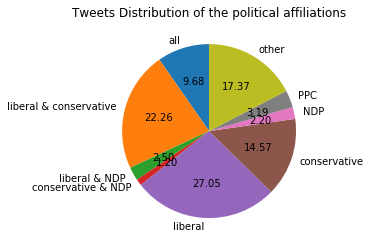

In [12]:
# seperate raw_elections into 8 subtables by their parties
df_all = raw_elections[raw_elections['party'] == 'all']
df_liberal_conservative = raw_elections[raw_elections['party'] == 'liberal & conservative']
df_liberal_NDP = raw_elections[raw_elections['party'] == 'liberal & NDP']
df_conservative_NDP = raw_elections[raw_elections['party'] == 'conservative & NDP']
df_liberal = raw_elections[raw_elections['party'] == 'liberal']
df_conservative = raw_elections[raw_elections['party'] == 'conservative']
df_NDP = raw_elections[raw_elections['party'] == 'NDP']
df_PPC = raw_elections[raw_elections['party'] == 'PPC']
df_other = raw_elections[raw_elections['party'] == 'other']

labels = ['all', 'liberal & conservative', 'liberal & NDP', 'conservative & NDP', 
          'liberal', 'conservative', 'NDP', 'PPC', 'other']
sizes = [len(df_all),len(df_liberal_conservative),len(df_liberal_NDP),len(df_conservative_NDP),
         len(df_liberal),len(df_conservative),len(df_NDP),len(df_PPC),len(df_other)]

plt.pie(sizes, labels=labels, autopct='%1.2f', startangle=90)
plt.title('Tweets Distribution of the political affiliations')
plt.show()


    Count plot 
    ✓ For Liberal and NDP, there are more positive public opinion on Twitter. 
    ✓ Liberal have the most positive tweets, it has high popularity among the yonger generation. Although there are large amount of 
    negative tweets, the chance to win the election is still high, since the reason of most negative opinions is 'others'. 
    ✓ For consevative party, there are more negative public opinion on Twitter, which relate to scandal and tell lies. The chance 
    for conservative party to win the election is low.

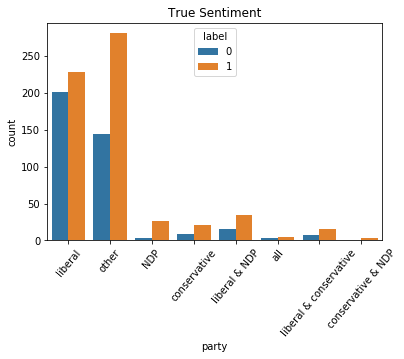

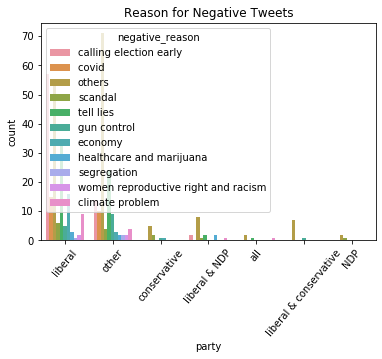

In [73]:
sns.countplot(x='party', hue='label', data=raw_elections)
plt.xticks(rotation=50)
plt.title ('True Sentiment')
plt.show()

negative_elections = raw_elections[raw_elections['negative_reason'].notnull()]
sns.countplot(x='party', hue='negative_reason', data=negative_elections)
plt.xticks(rotation=50)
plt.title ('Reason for Negative Tweets')
plt.show()



    Word cloud  

    Generic tweets   
    ✓ Visualize the word frequency, larger word appears more often.
    ✓ Neutral words like 'elxn42', 'canada','cdnpoli' appears in both 'sentiment 0' and 'sentiment 1' plots, don't contain much 
    information to distingush the sentiment.
    ✓ Words like 'trudeau' in the negative sentiment plot, looks larger than in the positive sentiment plot, which imply tweet contain 
    this word has higher potential to be negative. 

    Above rules also apply to 2019 Canadian Elections tweets.


In [74]:
def plt_wordcloud (df,label):
    # visualize the word frequency, the larger the word, more frequent the word appears in text.
    words_list = ''
    for text in df[df['label']==label]['new_text']: 
        words = text.split() 
        words_list += " ".join(words) 
    
    plt.figure(figsize = (10, 5))
    cloud=WordCloud(width = 1200, height = 600, collocations=False, background_color='white',).generate(words_list)
    
    plt.imshow(cloud,interpolation='bilinear')
    plt.title ('Sentiment '+ str(label),size=20,color='r')
    plt.axis('off')
    plt.show() 

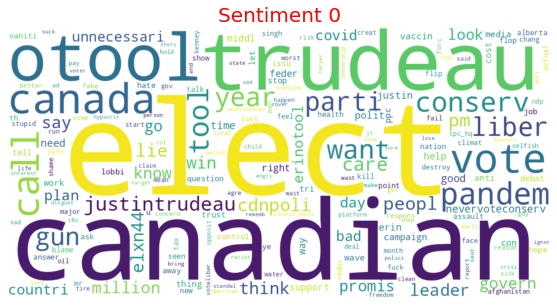

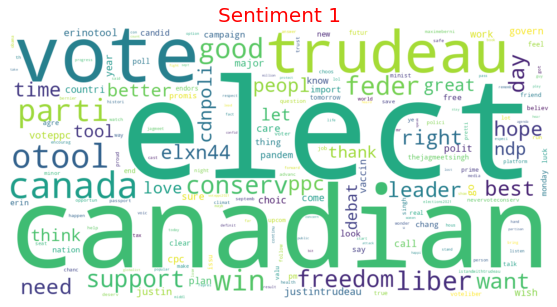

In [75]:
# Generic tweets   
plt_wordcloud (raw_elections,0)
plt_wordcloud (raw_elections,1)

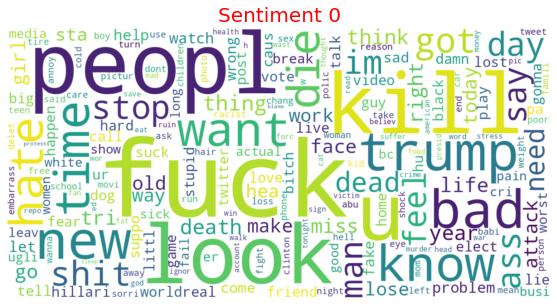

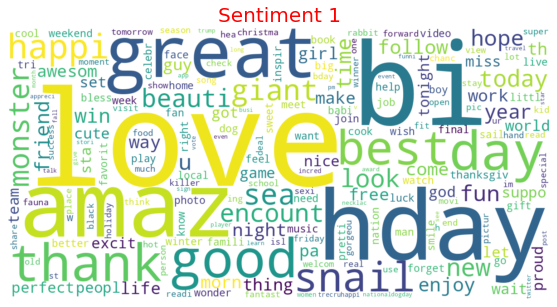

In [76]:
# 2019 Canadian Elections tweets 
plt_wordcloud (raw_sentiment,0)
plt_wordcloud (raw_sentiment,1)

## 3. Model preparation  
(instruction)
Split the generic tweets randomly into training data (70%) and test data (30%).  
Prepare the data to try seven classification algorithms – logistic regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest and XGBoost, where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Try two different types of features, Bag of Words (word frequency) and TF-IDF on all 7 models. (Hint: Be careful about when to split the dataset into training and testing set.)


    Prepare the data to classification algorithms
    ✓ Value: 'new_text' (cleand generic tweets)
    ✓ Target: 'label' (sentiment) 
    ✓ Split data randomly into training data (70%) and test data(30%)
    ✓ Features extraction: Bag of Words (word frequency) and TF-IDF
      (Only consider the top 2000 max_features)


In [77]:
# Value and Target
X = raw_sentiment['new_text']
y = raw_sentiment['label']

# Split data randomly into training data (70%) and test data(30%)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=66)

In [78]:
# Bag of Words (word frequency)
vec_wf = CountVectorizer(stop_words='english', max_features = 2000).fit(X_train)
X1_train = vec_wf.transform(X_train)
X1_test = vec_wf.transform(X_test)

In [79]:
# TF-IDF
vec_tfidf = TfidfVectorizer(stop_words='english', max_features = 2000).fit(X_train)
X2_train = vec_tfidf.transform(X_train)
X2_test = vec_tfidf.transform(X_test)

## 4. Model implementation and tuning 

(instruction)

**4.1)** Using both types of features (Bag of Words and TF-IDF), train models on the training data from generic tweets and apply the model to the test data to obtain an accuracy value.

**a.** Evaluate the trained model with the best performance on the Canadian Elections data. How well do your predictions match the sentiment labelled in the Canadian elections data?

### Part 4.1

Try two different types of features, Bag of Words (word frequency) and TF-IDF on 7 classification models:
      
    (hyperparameter tuning for some models)
      ✓ logistic regression (tune C to avoid overfitting)
      ✓ Naive Bayes (tune smoothing parameter alpha)
      ✓ Decision trees, Random Forest (tune max_depth to avoid overvitting)
      ✓ XGBoost 
      ✓ k-NN, SVM (no hyperparameter tuning due to slow algorithm)

Train models on the training data from generic tweets, and apply trained model to the test data to obtain an accuracy value.
    
    Model with highest testing accuracy: Logistic regression with Bagofword features

|Model|BagofWords |TF-IDF|
|--|--|--|
|Logistic Regression|  0.9537|0.9536|
|K-NN|0.9269| 0.8585
|Naive Bayes| 0.9270|0.9150|
|Linear SVM|0.9529|0.9525|
|Decision Trees| 0.9354| 0.9345|
|Random Forest| 0.8685| 0.8645 
|XGBoost|0.8677 | 0.8647 |
              
    

##### 1. Logistic Regression 

In [80]:
lr = LogisticRegression(penalty='l1', solver = 'liblinear', random_state=66)
grid = GridSearchCV(lr, {'C':[0.01, 0.1, 1, 10, 100]}, 
                    scoring='accuracy', cv=10, n_jobs=-1)

In [81]:
# Bag of Words (word frequency)
grid.fit(X1_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

lr_wf = LogisticRegression(C=best_hyper['C'], penalty='l1', solver = 'liblinear', random_state=66)
lr_wf.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = lr_wf.predict(X1_train)
y_test_predict = lr_wf.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'C': 10}
Train accuracy: 0.9559039953487527
Test accuracy: 0.953608934216742


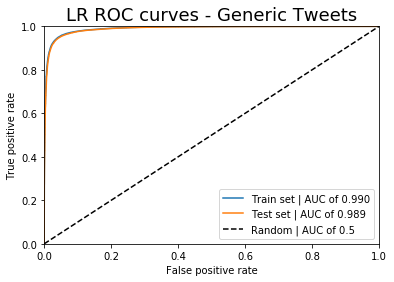

In [82]:
# ROC curves - Train set
scores_train = lr_wf.predict_proba(X1_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
auc_train = auc(fpr_train, tpr_train)

# ROC curves - Test Data
scores_test = lr_wf.predict_proba(X1_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test))
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('LR ROC curves - Generic Tweets', fontsize = 18)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

In [83]:
# TF-IDF
grid.fit(X2_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

lr_tfidf = LogisticRegression(C=best_hyper['C'], penalty='l1', solver = 'liblinear', random_state=66)
lr_tfidf.fit(X2_train, y_train)

# predict on train and test set
y_train_predict = lr_tfidf.predict(X2_train)
y_test_predict = lr_tfidf.predict(X2_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'C': 1}
Train accuracy: 0.9556210790789907
Test accuracy: 0.9535483714676777


##### 2. K-NN 

In [84]:
knn = KNeighborsClassifier(n_neighbors=5)

In [85]:
# Bag of Words (word frequency)
knn.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = knn.predict(X1_train)
y_test_predict = knn.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

In [ ]:
# TF-IDF
knn.fit(X2_train, y_train)

# predict on train and test set
y_train_predict = knn.predict(X2_train)
y_test_predict = knn.predict(X2_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

Train accuracy: 0.9020019570538294
Test accuracy: 0.8584890805363437


##### 3. Naive Bayes

In [ ]:
nb = MultinomialNB()
grid = GridSearchCV(nb, {'alpha':np.arange(0,2,0.2)}, scoring='accuracy', cv=10, n_jobs=-1)

In [ ]:
# Bag of Words (word frequency)
grid.fit(X1_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

nb_wf = MultinomialNB(alpha=best_hyper['alpha'])
nb_wf.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = nb_wf.predict(X1_train)
y_test_predict = nb_wf.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'alpha': 0.0}
Train accuracy: 0.9268233174917526
Test accuracy: 0.9269007618793832


In [ ]:
# TF-IDF
grid.fit(X2_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

nb_tfidf = MultinomialNB(alpha=best_hyper['alpha'])
nb_tfidf.fit(X2_train, y_train)

# predict on train and test set
y_train_predict = nb_tfidf.predict(X2_train)
y_test_predict = nb_tfidf.predict(X2_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'alpha': 1.4000000000000001}
Train accuracy: 0.914946025285966
Test accuracy: 0.914885112465025


##### 4. SVM (linear)

In [ ]:
# Bag of Words (word frequency)
supportvm_wf = LinearSVC(random_state=66, tol=1e-5)
supportvm_wf.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = supportvm_wf.predict(X1_train)
y_test_predict = supportvm_wf.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

Train accuracy: 0.9550656287878985
Test accuracy: 0.9528821812279703


In [ ]:
# TF-IDF
supportvm_tfidf = LinearSVC(random_state=66, tol=1e-5)
supportvm_tfidf.fit(X2_train, y_train)

# predict on train and test set
y_train_predict = supportvm_tfidf.predict(X2_train)
y_test_predict = supportvm_tfidf.predict(X2_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

Train accuracy: 0.9549462329309347
Test accuracy: 0.9525430298332102


#### 5. Decision Trees 

In [ ]:
tree = DecisionTreeClassifier(criterion="gini",random_state=66)
grid = GridSearchCV(tree , {'max_depth':[50,100,150]}, scoring='accuracy', cv=10, n_jobs=-1)

In [ ]:
# Bag of Words (word frequency)
grid.fit(X1_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

tree_wf = DecisionTreeClassifier(max_depth=best_hyper['max_depth'],criterion="gini", random_state=66)
# tree_wf = DecisionTreeClassifier(max_depth=100,criterion="gini", random_state=66)

tree_wf.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = tree_wf.predict(X1_train)
y_test_predict = tree_wf.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'max_depth': 150}
Train accuracy: 0.9636180059334549
Test accuracy: 0.9353129277244153


In [ ]:
# TF-IDF
grid.fit(X2_train, y_train)
best_hyper = grid.best_params_     
print('The best parameter:', best_hyper)

tree_tfidf = DecisionTreeClassifier(max_depth=best_hyper['max_depth'], criterion="gini", random_state=66)
tree_tfidf.fit(X2_train, y_train)

# predict on train and test set
y_train_predict = tree_tfidf.predict(X2_train)
y_test_predict = tree_tfidf.predict(X2_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'max_depth': 150}
Train accuracy: 0.9651701520739839
Test accuracy: 0.9344529366877021


#### 6. Random Forest  

In [ ]:
forest = RandomForestClassifier(criterion="gini", n_estimators=100, random_state=66)
grid = GridSearchCV(forest, {'max_depth':[10, 50]}, scoring='accuracy', cv=10, n_jobs=-1)

In [ ]:
# Bag of Words (word frequency)
grid.fit(X1_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

forest_wf = RandomForestClassifier(max_depth=best_hyper['max_depth'], criterion="gini",n_estimators = 100, random_state=66)
forest_wf.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = forest_wf.predict(X1_train)
y_test_predict = forest_wf.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'max_depth': 50}
Train accuracy: 0.8696015552608151
Test accuracy: 0.8630252304412602


In [ ]:
# TF-IDF
grid.fit(X1_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

forest_tfidf = RandomForestClassifier(max_depth=best_hyper['max_depth'], criterion="gini",n_estimators = 100, random_state=66)
forest_tfidf.fit(X2_train, y_train)

# predict on train and test set
y_train_predict = forest_tfidf.predict(X2_train)
y_test_predict = forest_tfidf.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'max_depth': 50}
Train accuracy: 0.874450065278387
Test accuracy: 0.8659564674959725


#### 7. XGBoost

In [ ]:
XGB = XGBClassifier(n_estimators=100,random_state=66)

In [ ]:
# Bag of Words (word frequency)
XGB.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = XGB.predict(X1_train)
y_test_predict = XGB.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

[15:57:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.9288997671780789
Test accuracy: 0.9267311861820031


In [ ]:
# TF-IDF
XGB.fit(X2_train, y_train)

# predict on train and test set
y_train_predict = XGB.predict(X2_train)
y_test_predict = XGB.predict(X2_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

[15:57:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.9296239290061852
Test accuracy: 0.927094562676389


### Part 4.2
    
    Apply trained model with best performance on the Canadian Elections data. 
    ✓ Logistic regression with Bagofword, Accuracy=0.6184

    The prediction accuracy is only 61.84%. Exploring more by visualizing the sentiment prediction results and the true sentiment for 
    each of the 3 parties/candidates. 
    
    Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.
    ✓ For all parties, large amount of tweets with positive sentiment are predicted have negative sentimen, that's why the testing 
    accuracy are only around 60%. This error apply for all parties, the liberal party still has the highest public support on Twiiter. 
    So the NLP analytics based on tweets are still useful. Use tweets related to political topic might be better.
 

    

In [ ]:
# Logistic regression with Bagofword
X = vec_wf.transform(raw_elections['new_text'])
y = raw_elections['label']

y_predict = lr_wf.predict(X)
accuracy = accuracy_score(y, y_predict)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.689620758483034


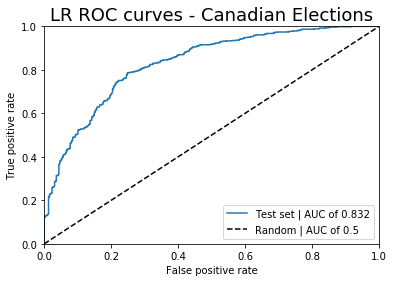

In [ ]:
# ROC curves - Canadian Elections data
scores_test = lr_wf.predict_proba(X)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y, scores_test)
auc_test  = auc(fpr_test, tpr_test)


# Plotting
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('LR ROC curves - Canadian Elections', fontsize = 18)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

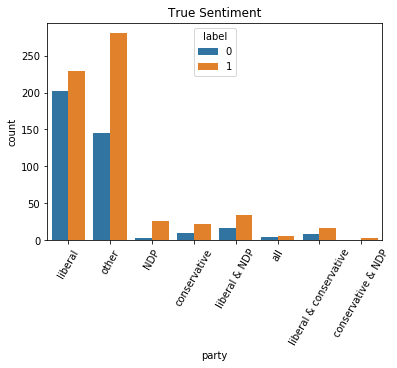

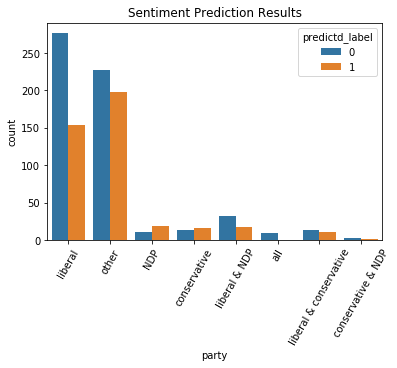

In [ ]:
raw_elections['predictd_label'] = lr_wf.predict(X)

sns.countplot(x='party', hue='label', data=raw_elections)
plt.xticks(rotation=60)
plt.title ('True Sentiment')
plt.show()

sns.countplot(x='party', hue='predictd_label', data=raw_elections)
plt.xticks(rotation=60)
plt.title ('Sentiment Prediction Results')
plt.show()

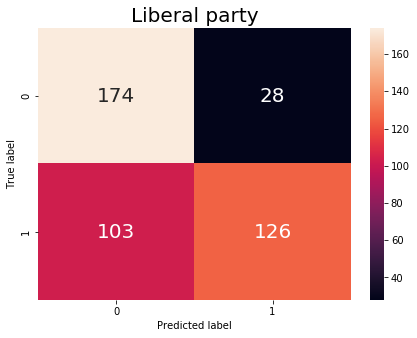

In [ ]:
# liberal
confusion_matrix_conservative = confusion_matrix(y_true = raw_elections[raw_elections.party == 'liberal']['label'], 
                    y_pred = raw_elections[raw_elections.party == 'liberal']['predictd_label'])
# Turn to dataframe
df_cm = pd.DataFrame( confusion_matrix_conservative, index=[0,1], columns=[0,1], )
# Create image
figsize = (7,5)
fontsize=14
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.0f',annot_kws={"size":20})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Liberal party",fontsize=20)
plt.show()

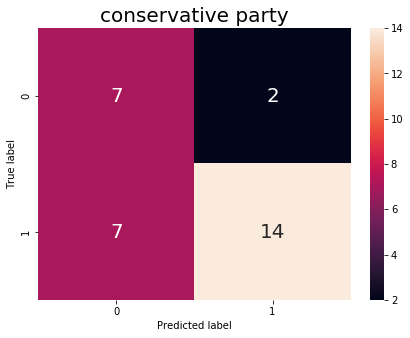

In [ ]:
# conservative
confusion_matrix_conservative = confusion_matrix(y_true = raw_elections[raw_elections.party == 'conservative']['label'], 
                    y_pred = raw_elections[raw_elections.party == 'conservative']['predictd_label'])
df_cm = pd.DataFrame( confusion_matrix_conservative, index=[0,1], columns=[0,1], )
# Create image
figsize = (7,5)
fontsize=14
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.0f',annot_kws={"size":20})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("conservative party",fontsize=20)
plt.show()

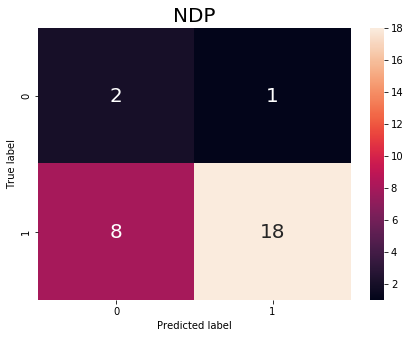

In [ ]:
# NDP
confusion_matrix_conservative = confusion_matrix(y_true = raw_elections[raw_elections.party == 'NDP']['label'], 
                    y_pred = raw_elections[raw_elections.party == 'NDP']['predictd_label'])
df_cm = pd.DataFrame( confusion_matrix_conservative, index=[0,1], columns=[0,1], )
# Create image
figsize = (7,5)
fontsize=14
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.0f',annot_kws={"size":20})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("NDP",fontsize=20)
plt.show()

### Part 4.3
    ✓ Value: 'new_text' (cleand election tweets)
    ✓ Target: 'negative_reason'  
    ✓ Split the negative Canadian elections tweets into training data (70%) and test data (30%). 
    ✓ Features extraction: Bag of Words (word frequency) and TF-IDF

    Train multi-class classification models to predict the reason for the negative tweets. 
    Tune the hyperparameters and chose the model with best score to test your prediction reason for negative sentiment tweets. 

    Model with best performance: Logistic regression with Bagofword. Prediction accuracy is 0.6126. 

|Model|BagofWords |TF-IDF|
|--|--|--|
|Logistic Regression|  0.6126|0.5927   
|SVM| 0.5530| 0.3510    
|Random Forest| 0.5795|0.5728|

    Try N-grams as feature engineering techniques. Logistic regression still have the best performance. 
    ✓ N-grams (CountVectorizer,unigrams and bigrams), testing accuracy = 0.6026
    ✓ N-grams (TfidfVectorizer,unigrams and bigrams), testing accuracy = 0.5762
    ✓ MLPClassifier, testing accuracy = 0.5629

In [ ]:
negative_elections = raw_elections[raw_elections.label == 0]

# Value and Target
X = negative_elections['new_text']
y = negative_elections['negative_reason']

# Split data randomly into training data (70%) and test data(30%)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=66)

In [ ]:
# Bag of Words (word frequency)
vec_wf = CountVectorizer(stop_words='english', max_features = 5000).fit(X_train)
X1_train = vec_wf.transform(X_train)
X1_test = vec_wf.transform(X_test)

In [ ]:
# TF-IDF
vec_tfidf = TfidfVectorizer(stop_words='english', max_features = 5000).fit(X_train)
X2_train = vec_tfidf.transform(X_train)
X2_test = vec_tfidf.transform(X_test)

#### 1. Logistic Regression

In [ ]:
lr = LogisticRegression(solver = 'liblinear',penalty='l1', random_state=66)
grid = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10,100]}, scoring='accuracy', cv=10, n_jobs=-1)

In [ ]:
# Bag of Words (word frequency)
grid.fit(X1_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

lr_wf = LogisticRegression(C=best_hyper['C'], penalty='l1', solver = 'liblinear', random_state=66)
lr_wf.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = lr_wf.predict(X1_train)
y_test_predict = lr_wf.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'C': 1}
Train accuracy: 0.8333333333333334
Test accuracy: 0.47863247863247865


(0, 180)

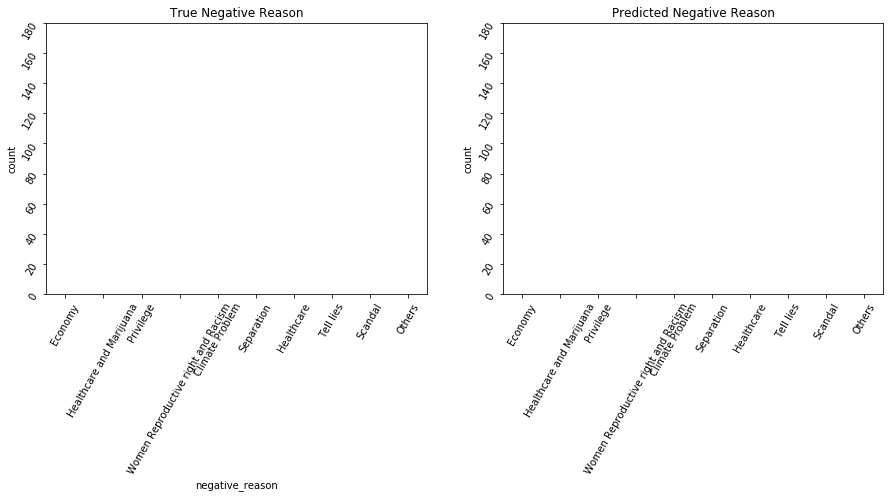

In [ ]:
reason_order = ['Economy','Healthcare and Marijuana','Privilege','Women Reproductive right and Racism','Climate Problem',
                'Separation','Healthcare','Tell lies','Scandal','Others']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(ax=axes[0],x = y_test,order=reason_order)
axes[0].set_title('True Negative Reason')
axes[0].tick_params(labelrotation=60)
axes[0].set_ylim([0, 180])

sns.countplot(ax=axes[1],x = lr_wf.predict(X1_test),order=reason_order)
axes[1].set_title('Predicted Negative Reason')
axes[1].tick_params(labelrotation=60)
axes[1].set_ylim([0, 180])

In [ ]:
# TF-IDF
grid.fit(X2_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

lr_tfidf = LogisticRegression(C=best_hyper['C'], penalty='l1', solver = 'liblinear', random_state=66)
lr_tfidf.fit(X2_train, y_train)

# predict on train and test set
y_train_predict = lr_tfidf.predict(X2_train)
y_test_predict = lr_tfidf.predict(X2_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'C': 10}
Train accuracy: 1.0
Test accuracy: 0.5042735042735043


#### 2. SVM

In [ ]:
supportvm = svm.SVC(random_state=66)
grid = GridSearchCV(supportvm, {'C':np.arange(1,11,1)}, 
                    scoring='accuracy', cv=10, n_jobs=-1)

In [ ]:
# Bag of Words (word frequency)
grid.fit(X1_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

svm_wf = svm.SVC(C=best_hyper['C'], random_state=66)
svm_wf.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = svm_wf.predict(X1_train)
y_test_predict = svm_wf.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'C': 2}
Train accuracy: 1.0
Test accuracy: 0.47863247863247865


In [ ]:
# TF-IDF
grid.fit(X2_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

svm_tfidf = svm.SVC(C=best_hyper['C'], random_state=66)
svm_tfidf.fit(X2_train, y_train)

# predict on train and test set
y_train_predict = svm_tfidf.predict(X2_train)
y_test_predict = svm_tfidf.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'C': 2}
Train accuracy: 1.0
Test accuracy: 0.358974358974359


#### 3. Random Forest

In [ ]:
forest = RandomForestClassifier(criterion="gini", random_state=66,n_estimators=100,max_depth=50)
grid = GridSearchCV(forest, {'min_samples_split':[10,20,30,40,50,100,500]}, scoring = 'accuracy', cv=10, n_jobs=-1)

In [ ]:
# Bag of Words (word frequency)
grid.fit(X1_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

forest_wf = RandomForestClassifier(min_samples_split=best_hyper['min_samples_split'],
                                   n_estimators = 100, criterion="gini", random_state=66, max_depth=50)
forest.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = forest.predict(X1_train)
y_test_predict = forest.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'min_samples_split': 10}
Train accuracy: 0.9962962962962963
Test accuracy: 0.48717948717948717


In [ ]:
# TF-IDF
grid.fit(X2_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

forest_tfidf = RandomForestClassifier(min_samples_split=best_hyper['min_samples_split'],
                                      n_estimators = 100, criterion="gini", random_state=66, max_depth=50)
forest_tfidf.fit(X2_train, y_train)

# predict on train and test set
y_train_predict = forest_tfidf.predict(X2_train)
y_test_predict = forest_tfidf.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'min_samples_split': 30}
Train accuracy: 0.9333333333333333
Test accuracy: 0.47863247863247865


#### N-grams (CountVectorizer): unigrams and bigrams  

In [ ]:
# N-grams (CountVectorizer): unigrams and bigrams
vec_ngram_wf = CountVectorizer(ngram_range=(1,2), stop_words='english', max_features = 5000).fit(X_train)
X3_train = vec_ngram_wf.transform(X_train)
X3_test = vec_ngram_wf.transform(X_test)

In [ ]:
lr = LogisticRegression(solver = 'liblinear', random_state=66)
grid = GridSearchCV(lr, {'C':[0.01, 0.1, 1, 10, 100], 'penalty':('l1','l2')}, 
                    scoring='accuracy', cv=10, n_jobs=-1)

In [ ]:
grid.fit(X3_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

lr_ngram_wf = LogisticRegression(C= best_hyper['C'], penalty=best_hyper['penalty'], solver = 'liblinear', random_state=66)
lr_ngram_wf.fit(X3_train, y_train)

# predict on train and test set
y_train_predict = lr_ngram_wf.predict(X3_train)
y_test_predict = lr_ngram_wf.predict(X3_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'C': 1, 'penalty': 'l1'}
Train accuracy: 0.8481481481481481
Test accuracy: 0.4700854700854701


#### N-grams (TfidfVectorizer): unigrams and bigrams 

In [ ]:
# N-grams (TfidfVectorizer): unigrams and bigrams
vec_ngram_idf = TfidfVectorizer(ngram_range=(1,2), stop_words='english', max_features = 5000).fit(X_train)
X4_train = vec_ngram_idf.transform(X_train)
X4_test = vec_ngram_idf.transform(X_test)

In [ ]:
lr = LogisticRegression(solver = 'liblinear', random_state=66)
grid = GridSearchCV(lr, {'C':[0.01, 0.1, 1, 10, 100], 'penalty':('l1','l2')}, 
                    scoring='accuracy', cv=10, n_jobs=-1)

In [ ]:
grid.fit(X4_train, y_train)
best_hyper = grid.best_params_
print('The best parameter:', best_hyper)

lr_ngram_idf = LogisticRegression(C=best_hyper['C'], penalty=best_hyper['penalty'], solver = 'liblinear', random_state=66)
lr_ngram_idf.fit(X3_train, y_train)

# predict on train and test set
y_train_predict = lr_ngram_idf.predict(X3_train)
y_test_predict = lr_ngram_idf.predict(X3_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

The best parameter: {'C': 10, 'penalty': 'l1'}
Train accuracy: 1.0
Test accuracy: 0.46153846153846156


####  MLPClassifier  

In [ ]:
mlp = MLPClassifier(activation='logistic',alpha=1,learning_rate='adaptive',max_iter=500,random_state=66)
mlp.fit(X1_train, y_train)

# predict on train and test set
y_train_predict = mlp.predict(X1_train)
y_test_predict = mlp.predict(X1_test)

# calculate train and test accuracy
print("Train accuracy: {}".format(accuracy_score(y_train, y_train_predict)))
print("Test accuracy: {}".format(accuracy_score(y_test, y_test_predict)))

Train accuracy: 0.8296296296296296
Test accuracy: 0.46153846153846156


## 5. Results 

What can you say about the distribution of the political affiliations of the tweets?
 
    Tweet related to single party: Liberal (20.44%), Conservatives (15.71%), NDP (6.89%)
    Tweet related to more than one party
    Tweet related to other party: Other
    For tweets only relate to one party, liberal is the highly discussed topic on Twitter, around 20% tweets relate to this party. 
    Using more explicit keywords related to the party would lead to more accurate results.


Explain how each party is viewed in the public eye based on the sentiment value. 

    NDP: fewer tweets about NDP, most tweets are positive.

    Liberal: more than 500 positive tweets and most tweets are positive, high popularity among the younger generation. Although there’re 
    also lots of opposition, the chance for liberal to win the election is still high, since the reason of most negative tweets is 
    ’Others’. Public have a pretty good view on Liberal party. 

    Conservative:  most tweets are negative, and reasons for most of them are related to ‘scandal’ and ’tell lies, all indicates more 
    negative public impression. The chance to win the election is lower than liberal.


How well do your predictions match the sentiment labelled in the Canadian elections data?

    Train models on training data from generic tweets. Apply model on testing data to compute the testing accuracy. The best model is
    Logistic regression with Bagofword features, with highest accuracy = 0.9537,and AUC = 0.989.
  
    The model doesn't perform well on Canadian election data，accuracy = 0.6184, AUC =0.725. 
    Large FN lower the testing accuracy and AUC  score.

|Party|FN|
|-|-|
|Liberal|141|
|Conservative|63|
|NDP|57 |

      
 


Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

    For all parties, large amount of tweets with positive sentiment are predicted have negative sentimen, that's why the testing 
    accuracy are only around 60%. This error apply for all parties, the liberal party still has the highest public support on Twiiter. 
    And the predicted result is consistent as the result of Canadian election 2019, the liberal party won.
    So the NLP analytics based on tweets are still useful. Use tweets related to political topic might be better.

For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct 
    negative reasons. 

    Model with highest testing accuracy: logistic regression with BagofWords.

    1. For all three models, the training accuray is much higher than testing accuracy. The models are overfitting. The max_features 
    are set equal to 5000, but there are only 1007 negative tweets. The data does not contain enough information to be trained. 
    Computed accuracy are stored in below table.

    2. The dataset is also imbalanced. Three models are all sensitive to the imbalanced data. The small weighted class tend to be 
    predicted as larger weighted class. There are few negative tweets with reason 'privilage'. But there's no predictive negative tweet 
    with this reason.

    
|Model|BagofWords test_acc |BagofWords train_acc |T F-IDF test_acc | TF-IDF train_acc|
|--|--|--|--|--|
|Logistic Regression|  0.6126|0.8580|0.5927|0.9972| 
|Linear SVM| 0.5530|0.9943| 0.3510| 0.9972|   
|Random Forest| 0.5795|0.8978|0.5728|0.8082| 
 

For both models, suggest one way you can improve the accuracy of your models.
    
    First model: 
    The model is trained on generic tweets, however the content between generic tweet and Canadian election are different. Some word 
    indicate a positive sentiment in generic tweet, might contribute a negative sentiment in Canadian election data. Try to train the
    model on data more related to political topics.

    Second model:
    For all three models, the training accuray is much higher than testing accuracy. The models are overfitting. Try hyperparameter 
    tuning or decrease the number of text fetures.